In [2]:
!unzip my_augmented_model.zip

Archive:  my_augmented_model.zip
   creating: my_augmented_model/
  inflating: my_augmented_model/model.safetensors  
  inflating: my_augmented_model/config.json  


In [3]:
# --- Core Installations ---
!pip install -q --upgrade pip
!pip install -q plantcv transformers huggingface_hub pillow matplotlib opencv-python-headless tqdm
print("✅ Installations complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:00
✅ Installations complete.


In [4]:
#  A lot of the comments in this code is written by AI to make it as verbally clear as possible

# Core Imports
import sys, os, tempfile, warnings
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
warnings.filterwarnings('ignore')

# Configuration
# Define two separate paths for the two components
ORIGINAL_HUB_ID = "linkanjarad/mobilenet_v2_1.0_224-plant-disease-identification"
LOCAL_MODEL_PATH = "./my_augmented_model"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

try:
    print(f"Loading feature extractor from original source: '{ORIGINAL_HUB_ID}'...")

    feature_extractor = AutoFeatureExtractor.from_pretrained(ORIGINAL_HUB_ID)

    print(f"Loading your fine-tuned model from local path: '{LOCAL_MODEL_PATH}'...")

    model = AutoModelForImageClassification.from_pretrained(LOCAL_MODEL_PATH).to(DEVICE)
    model.eval()

    print("✅ Model and feature extractor loaded successfully onto device:", DEVICE)

except Exception as e:
    print(f"❌ Error loading model: {e}")

Loading feature extractor from original source: 'linkanjarad/mobilenet_v2_1.0_224-plant-disease-identification'...


preprocessor_config.json:   0%|          | 0.00/408 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Loading your fine-tuned model from local path: './my_augmented_model'...
✅ Model and feature extractor loaded successfully onto device: cpu


Please upload one or more plant images.


Saving images (4).jpg to images (4).jpg

Processing: images (4).jpg
🔄 Preprocessing image...
🔍 Analyzing image...

📊 PREDICTION RESULT:
🟢 Disease: Corn (Maize) with Cercospora and Gray Leaf Spot
   Confidence: 99.76%


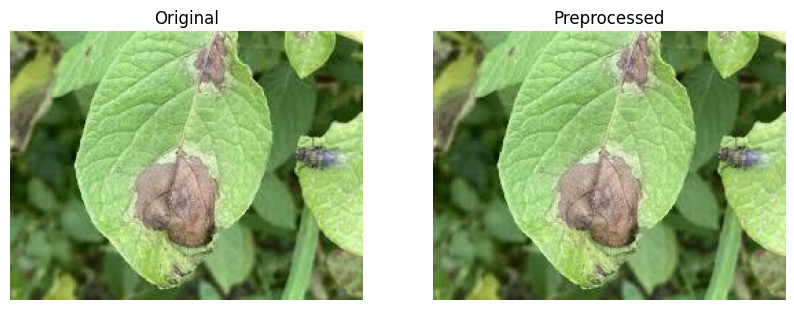

In [6]:
from google.colab import files

# Helper Functions for Inference

def preprocess_segment_crop_cv(input_path):
    img = cv2.imread(input_path)
    if img is None: raise ValueError("Could not read image")
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Using a broad green range for general purpose segmentation
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Clean the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find the largest contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)

        # Crop the original image
        cropped_img = img[y:y+h, x:x+w]

        # Save to a temporary path
        out_path = os.path.join(tempfile.gettempdir(), "preprocessed.jpg")
        cv2.imwrite(out_path, cropped_img)
        return out_path, cropped_img
    else:

        return input_path, img

def predict_image(model, feature_extractor, image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=img, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = logits.argmax(-1).item()
    confidence = F.softmax(logits, dim=1).max().item()
    label = model.config.id2label[predicted_class_id]

    return label, confidence

# --- Main Inference Loop ---
print("Please upload one or more plant images.")
uploaded = files.upload()

if not uploaded:
    print("No files were uploaded.")
else:
    for filename, content in uploaded.items():
        print(f"\n{'='*50}\nProcessing: {filename}\n{'='*50}")

        # Save the uploaded file temporarily
        with open(filename, 'wb') as f:
            f.write(content)

        try:
            # Preprocess the image
            print("🔄 Preprocessing image...")
            preproc_path, preproc_img_cv = preprocess_segment_crop_cv(filename)

            # Make prediction
            print("🔍 Analyzing image...")
            label, confidence = predict_image(model, feature_extractor, preproc_path)

            # Display results
            print(f"\n📊 PREDICTION RESULT:")
            emoji = "🟢" if confidence > 0.9 else "🟡" if confidence > 0.6 else "🔴"
            print(f"{emoji} Disease: {label}")
            print(f"   Confidence: {confidence*100:.2f}%")

            # Show original and preprocessed images
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            original_img_cv = cv2.imread(filename)
            axs[0].imshow(cv2.cvtColor(original_img_cv, cv2.COLOR_BGR2RGB))
            axs[0].set_title("Original")
            axs[0].axis("off")

            axs[1].imshow(cv2.cvtColor(preproc_img_cv, cv2.COLOR_BGR2RGB))
            axs[1].set_title("Preprocessed")
            axs[1].axis("off")

            plt.show()

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")